<a href="https://colab.research.google.com/github/desirit/detectron2-instance-segmentation/blob/main/Detectron2_custom_coco_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train Detectron2 with Custom COCO Datasets

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook is inspired from work done at [DLology](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/). It will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

### Cleanup any existing datasets

In [1]:
%%bash
rm -rf data/
rm -f data.zip

# Install detectron2

In [2]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-fvcowvm4
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-fvcowvm4
  Created wheel for fvcore: filename=fvcore-0.1.5-cp37-none-any.whl size=63295 sha256=19ba10768fb610ce2a922667776a6e613ea471fef99fcc1ef2edb4fcbff996d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ljs0y2u/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
Successfully built fvcore


'1.8.1+cu101'

In [3]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2_repo
  Found existing installation: detectron2 0.4
    Can't uninstall 'detectron2'. No files were found to uninstall.
  Running setup.py develop for detectron2


In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [5]:
# download, decompress the data
# !wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
!wget https://github.com/desirit/detectron2-instance-segmentation/raw/main/data.zip
! sleep 5


--2021-05-06 00:09:03--  https://github.com/desirit/detectron2-instance-segmentation/raw/main/data.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/desirit/detectron2-instance-segmentation/main/data.zip [following]
--2021-05-06 00:09:04--  https://raw.githubusercontent.com/desirit/detectron2-instance-segmentation/main/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4612660 (4.4M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   4.40M  --.-KB/s    in 0.1s    

2021-05-06 00:09:04 (37.7 MB/s) - ‘data.zip’ saved [4612660/4612660]



In [8]:
!unzip -q /content/data.zip

replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [9]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("fruits_nuts", {}, "./data/trainval.json", "./data/images")

In [10]:
fruits_nuts_metadata = MetadataCatalog.get("fruits_nuts")
dataset_dicts = DatasetCatalog.get("fruits_nuts")

[05/06 00:10:11 d2.data.datasets.coco]: Loaded 18 images in COCO format from ./data/trainval.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



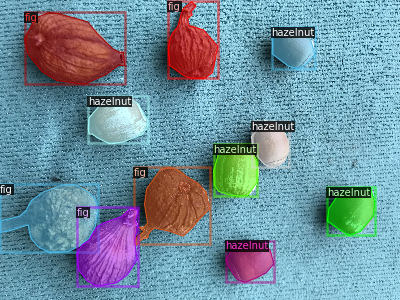

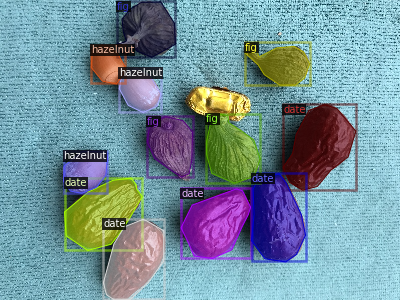

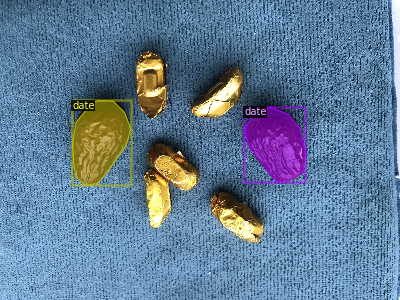

In [11]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("fruits_nuts",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/06 00:13:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[05/06 00:13:06 d2.engine.train_loop]: Starting training from iteration 0
[05/06 00:13:15 d2.utils.events]:  eta: 0:02:05  iter: 19  total_loss: 2.163  loss_cls: 0.6714  loss_box_reg: 0.8858  loss_mask: 0.5257  loss_rpn_cls: 0.01234  loss_rpn_loc: 0.02117  time: 0.4559  data_time: 0.0153  lr: 0.0012854  max_mem: 2341M
[05/06 00:13:24 d2.utils.events]:  eta: 0:01:56  iter: 39  total_loss: 0.8193  loss_cls: 0.2637  loss_box_reg: 0.4748  loss_mask: 0.08554  loss_rpn_cls: 0.002351  loss_rpn_loc: 0.02408  time: 0.4581  data_time: 0.0075  lr: 0.0026174  max_mem: 2341M
[05/06 00:13:33 d2.utils.events]:  eta: 0:01:47  iter: 59  total_loss: 0.489  loss_cls: 0.1167  loss_box_reg: 0.2825  loss_mask: 0.06921  loss_rpn_cls: 0.001767  loss_rpn_loc: 0.02677  time: 0.4580  data_time: 0.0087  lr: 0.0039494  max_mem: 2341M
[05/06 00:13:42 d2.utils.events]:  eta: 0:01:38  iter: 79  total_loss: 0.4208  loss_cls: 0.09976  loss_box_reg: 0.2157  loss_mask: 0.06713  loss_rpn_cls: 0.001551  loss_rpn_loc: 0.023

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("fruits_nuts", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [15]:
!wget https://idsb.tmgrup.com.tr/ly/uploads/images/2021/03/21/101785.jpg

--2021-05-06 00:15:47--  https://idsb.tmgrup.com.tr/ly/uploads/images/2021/03/21/101785.jpg
Resolving idsb.tmgrup.com.tr (idsb.tmgrup.com.tr)... 52.84.169.9, 52.84.169.63, 52.84.169.86, ...
Connecting to idsb.tmgrup.com.tr (idsb.tmgrup.com.tr)|52.84.169.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 664006 (648K) [image/jpeg]
Saving to: ‘101785.jpg’

101785.jpg          100%[===================>] 648.44K  --.-KB/s    in 0.03s   

2021-05-06 00:15:48 (20.7 MB/s) - ‘101785.jpg’ saved [664006/664006]



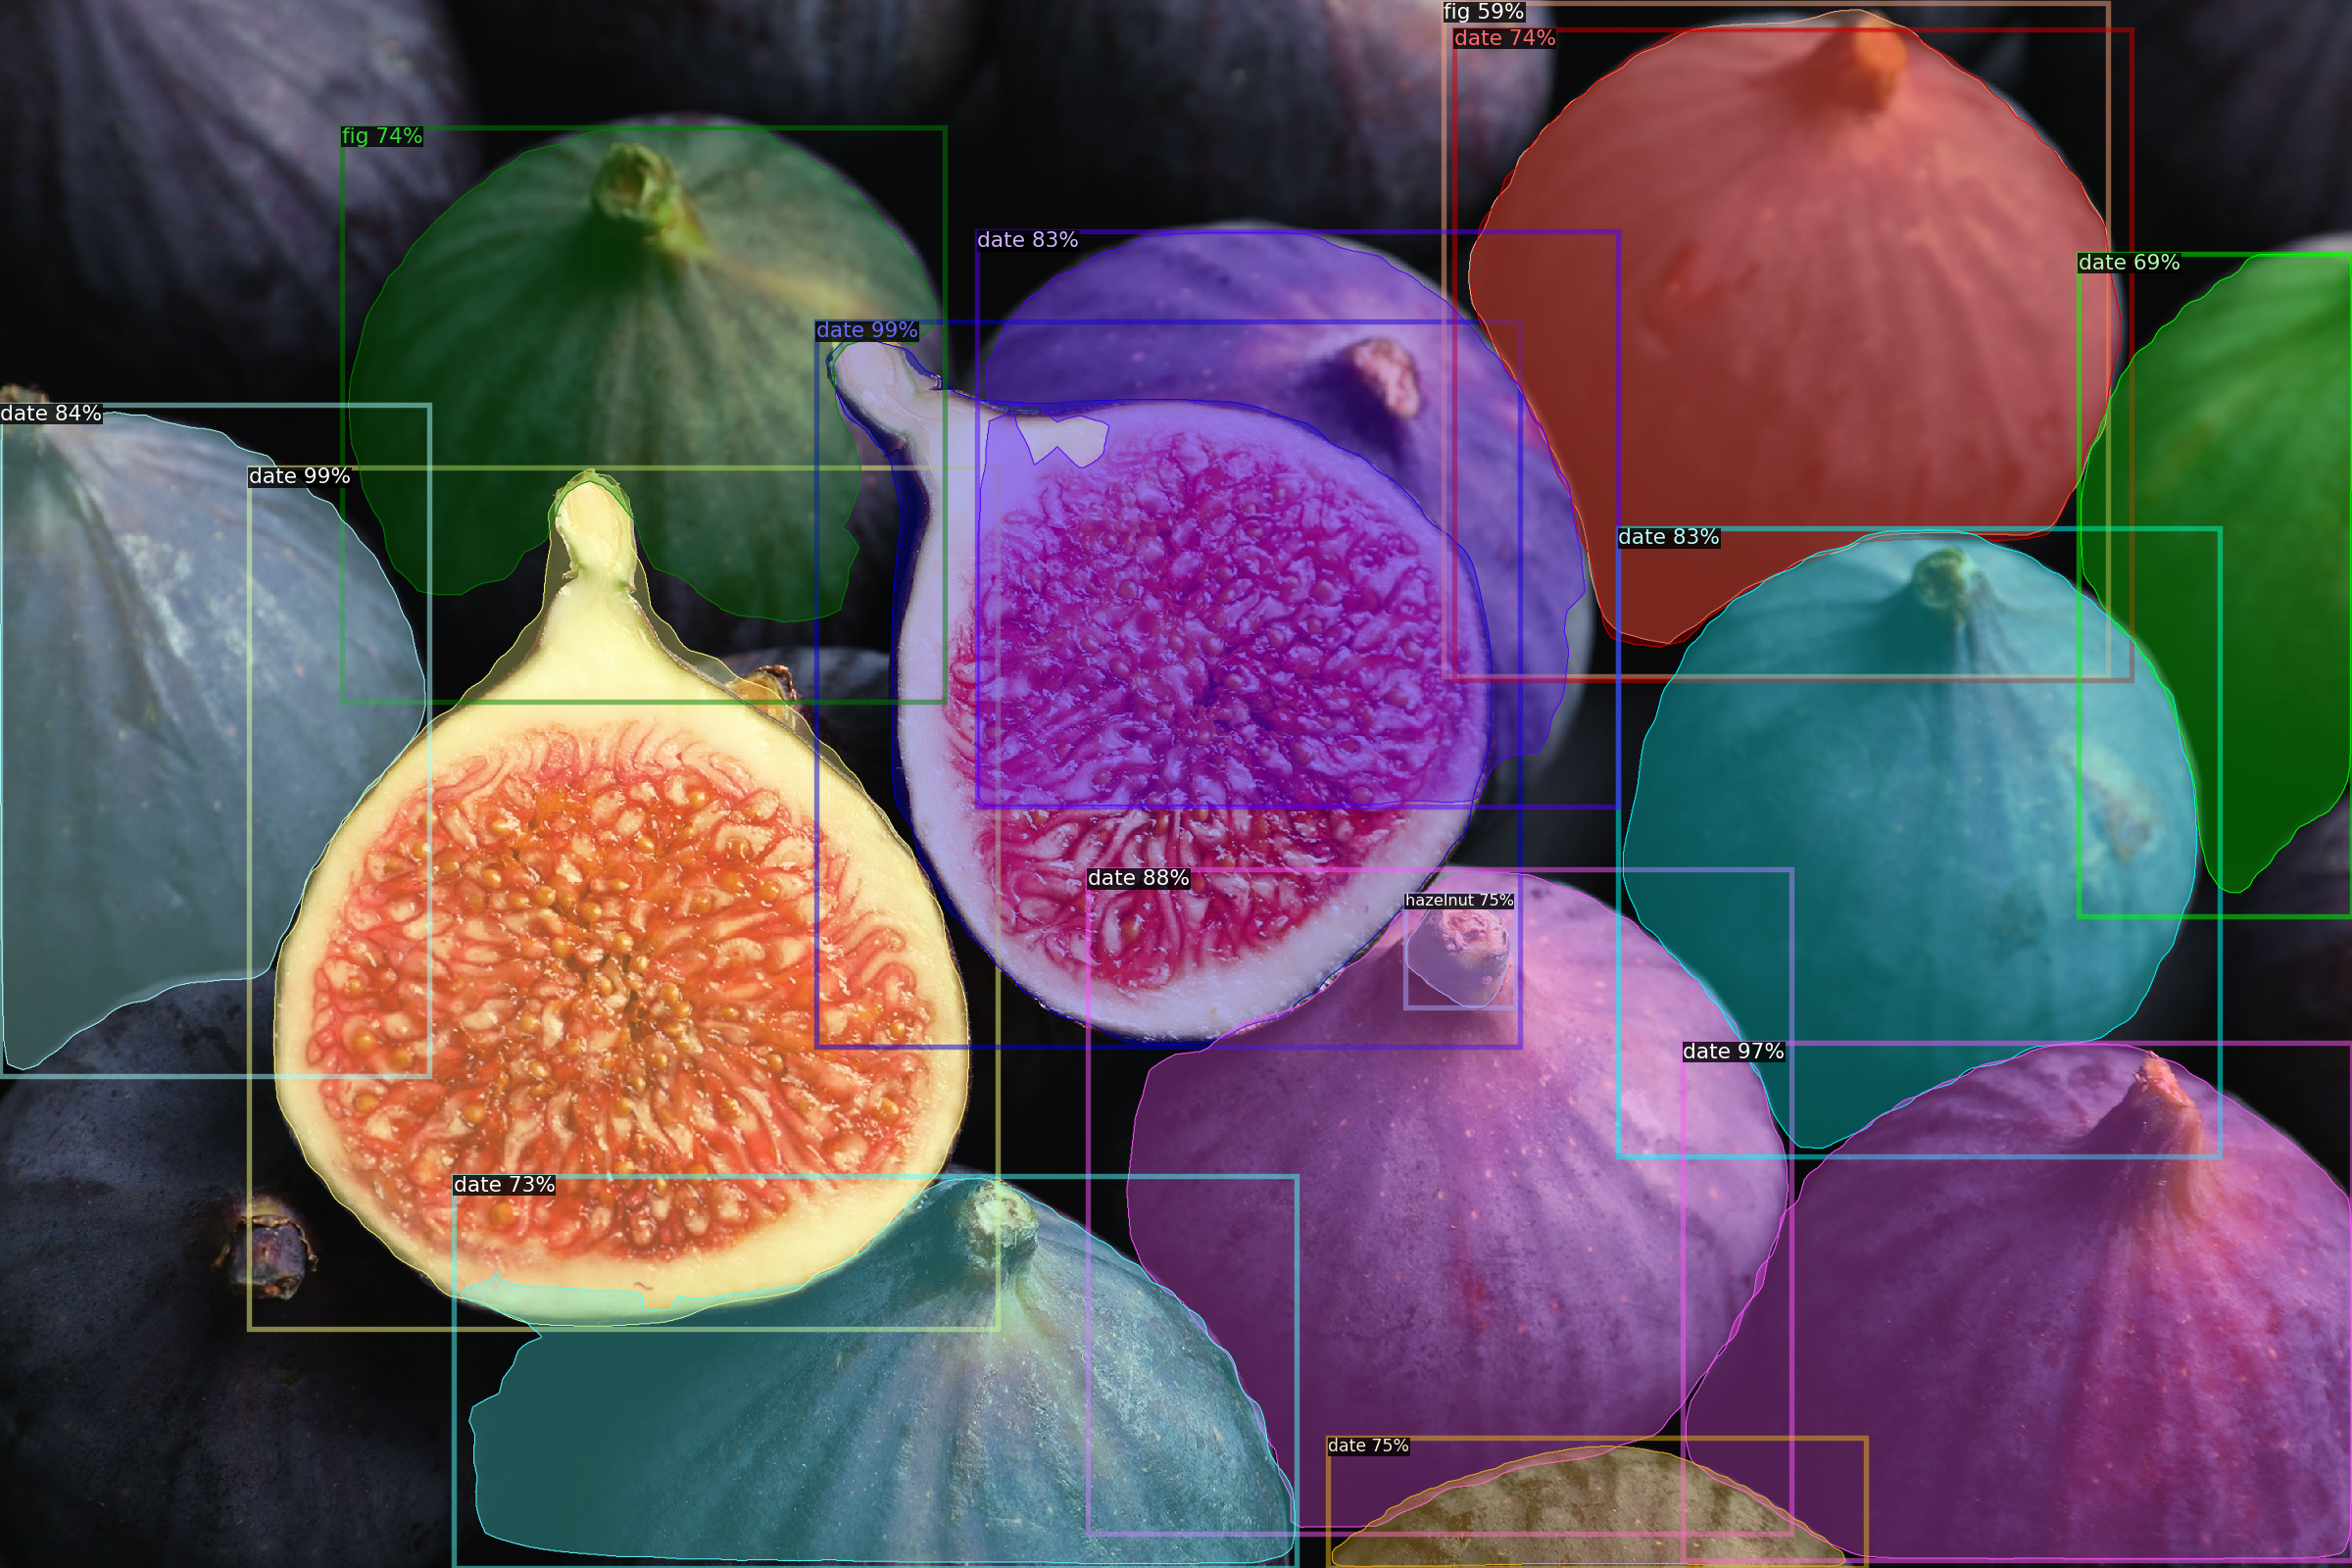

In [16]:
from detectron2.utils.visualizer import ColorMode

#im = "shutterstock_519484543.jpg"
im = cv2.imread("101785.jpg")

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                  metadata=fruits_nuts_metadata, 
                  scale=0.8, 
                  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

#for d in random.sample(dataset_dicts, 3):    
#    im = cv2.imread(d["file_name"])
#    outputs = predictor(im)
#    v = Visualizer(im[:, :, ::-1],
#                   metadata=fruits_nuts_metadata, 
#                   scale=0.8, 
#                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
#    )
#    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#    cv2_imshow(v.get_image()[:, :, ::-1])

In [17]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='./data/images', json_file='./data/trainval.json', name='fruits_nuts', thing_classes=['date', 'fig', 'hazelnut'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2})

## Benchmark inference speed

In [18]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.17,fps:5.96
